In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
from sklearn.compose import ColumnTransformer
import re
import tensorflow as tf
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_auc_score, roc_curve
)
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
from sklearn.datasets import load_diabetes


file_path = './adult 3 (1).csv'
df = pd.read_csv(file_path)
df = df.replace('?', pd.NA).dropna()
print(f"Размер датасета после удаления пропусков: {df.shape}\n")

Размер датасета после удаления пропусков: (45222, 15)



### Дескриптивный анализ (для числовых признаков)

In [53]:
numeric_cols = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
df_analysis = df.copy()
df_analysis['income_num'] = (df_analysis['income'] == '>50K').astype(int)

for col in numeric_cols:
    print(f"\n--- {col.upper()} ---")

    desc = df_analysis[col].describe()
    print(desc)

    mode_value = df_analysis[col].mode()
    print(f"Мода: {mode_value.iloc[0]}")

    sk = skew(df_analysis[col])
    kt = kurtosis(df_analysis[col])
    print(f"Асимметрия: {sk:.3f}")
    print(f"Эксцесс: {kt:.3f}")


--- AGE ---
count    45222.000000
mean        38.547941
std         13.217870
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64
Мода: 36
Асимметрия: 0.533
Эксцесс: -0.156

--- EDUCATIONAL-NUM ---
count    45222.000000
mean        10.118460
std          2.552881
min          1.000000
25%          9.000000
50%         10.000000
75%         13.000000
max         16.000000
Name: educational-num, dtype: float64
Мода: 9
Асимметрия: -0.311
Эксцесс: 0.635

--- CAPITAL-GAIN ---
count    45222.000000
mean      1101.430344
std       7506.430084
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64
Мода: 0
Асимметрия: 11.789
Эксцесс: 150.135

--- CAPITAL-LOSS ---
count    45222.000000
mean        88.595418
std        404.956092
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max     

### Построение гистограмм

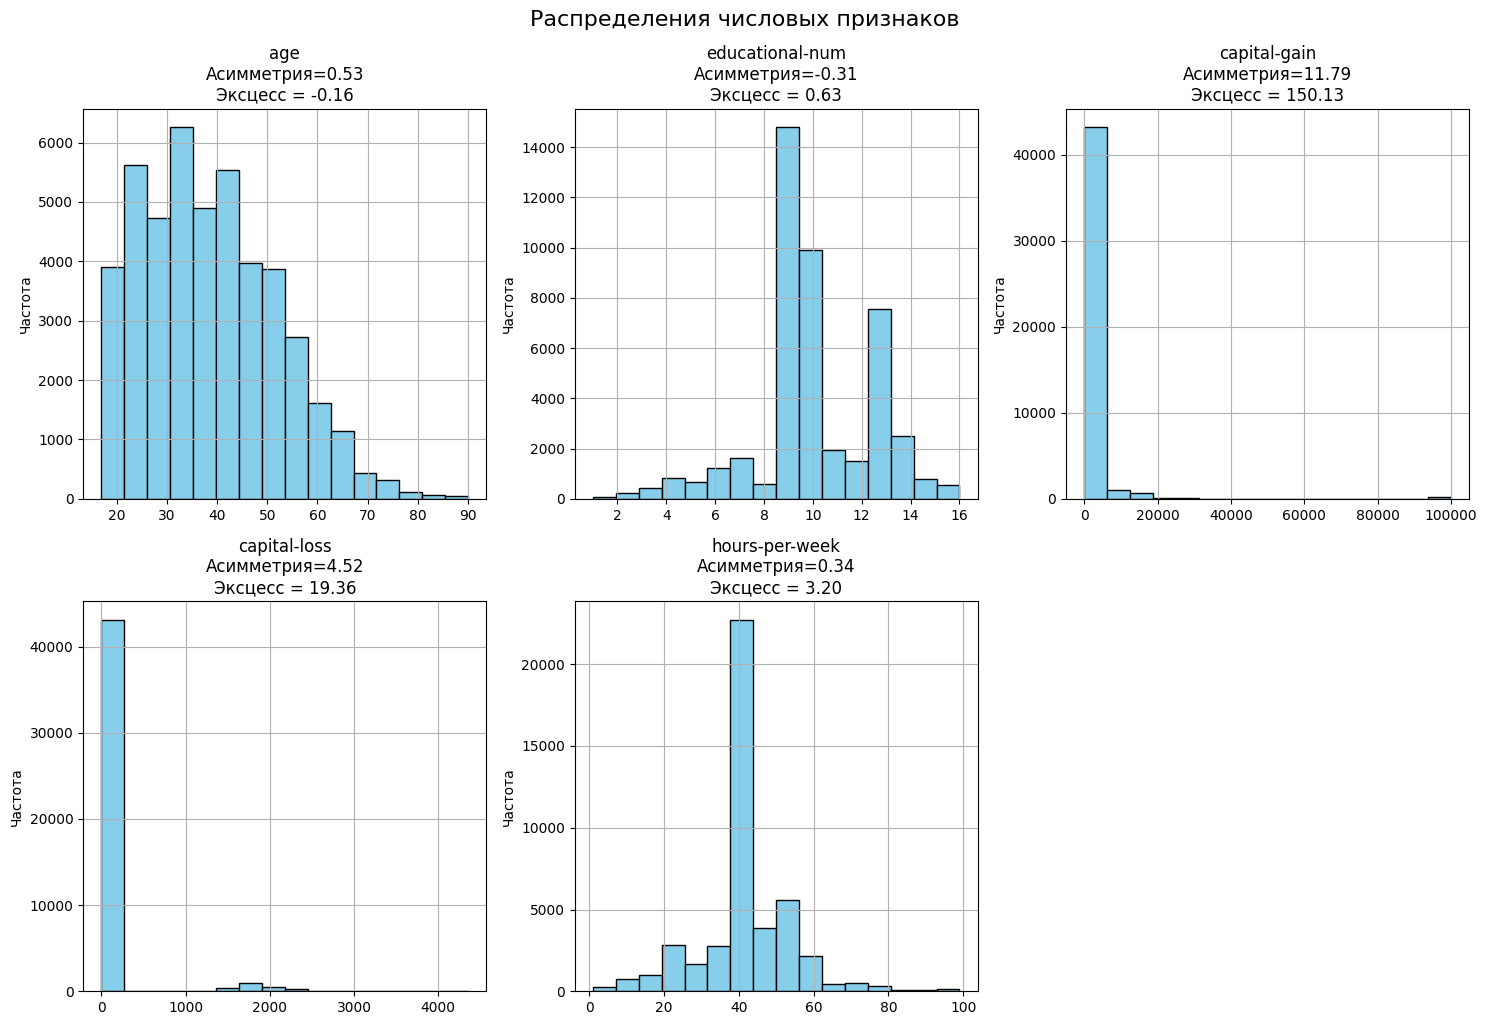

In [54]:
count_intervals = int(1 + math.log2(df_analysis.shape[0]))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    df_analysis[col].hist(bins=count_intervals, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'{col}\nАсимметрия={skew(df_analysis[col]):.2f}\nЭксцесс = {kurtosis(df_analysis[col]):.2f}')
    axes[i].set_ylabel('Частота')
axes[-1].axis('off')
plt.tight_layout()
plt.suptitle("Распределения числовых признаков", y=1.02, fontsize=16)
plt.show()

### Анализ категориальных данных (распределение объектов по классам + значения с доходом >50K в каждой категории)

In [55]:
categorical_cols = ['income','workclass', 'education', 'marital-status', 
                    'occupation', 'relationship', 'race', 'gender', 
                    'native-country']

df['income_num'] = (df['income'] == '>50K').astype(int)

for col in categorical_cols:
    print(f"\n--- {col.upper()} ---")

    dist = df[col].value_counts(normalize=True) * 100
    print("Распределение категорий (% от общего числа):")
    for cat, pct in dist.items():
        print(f"  {cat}: {pct:.2f}%")
    
    income_by_cat = df.groupby(col)['income_num'].mean().sort_values(
        ascending=False
    )
    print("\nДоля с доходом >50K в каждой категории:")
    for cat, prop in income_by_cat.items():
        print(f"  {cat}: {prop:.2%}")


--- INCOME ---
Распределение категорий (% от общего числа):
  <=50K: 75.22%
  >50K: 24.78%

Доля с доходом >50K в каждой категории:
  >50K: 100.00%
  <=50K: 0.00%

--- WORKCLASS ---
Распределение категорий (% от общего числа):
  Private: 73.65%
  Self-emp-not-inc: 8.39%
  Local-gov: 6.86%
  State-gov: 4.30%
  Self-emp-inc: 3.64%
  Federal-gov: 3.11%
  Without-pay: 0.05%

Доля с доходом >50K в каждой категории:
  Self-emp-inc: 55.41%
  Federal-gov: 39.05%
  Local-gov: 29.52%
  Self-emp-not-inc: 27.90%
  State-gov: 26.72%
  Private: 21.77%
  Without-pay: 9.52%

--- EDUCATION ---
Распределение категорий (% от общего числа):
  HS-grad: 32.69%
  Some-college: 21.89%
  Bachelors: 16.74%
  Masters: 5.56%
  Assoc-voc: 4.33%
  11th: 3.58%
  Assoc-acdm: 3.33%
  10th: 2.70%
  7th-8th: 1.82%
  Prof-school: 1.74%
  9th: 1.49%
  12th: 1.28%
  Doctorate: 1.20%
  5th-6th: 0.99%
  1st-4th: 0.49%
  Preschool: 0.16%

Доля с доходом >50K в каждой категории:
  Prof-school: 75.41%
  Doctorate: 73.35%
  Mas

### Провести отбор наиболее информативных признаков. 

In [56]:
print("\nКорреляция числовых признаков с доходом (>50K):")
corr_with_target = df_analysis[numeric_cols + ['income_num']].corr()['income_num'].abs().sort_values(ascending=False)
print(corr_with_target.drop('income_num'))

print("\nМаксимальная доля >50K в категориях:")
cat_strength = {}
for col in categorical_cols:
    max_prop = df_analysis.groupby(col)['income_num'].mean().max()
    min_prop = df_analysis.groupby(col)['income_num'].mean().min()
    range_prop = max_prop - min_prop
    cat_strength[col] = {'max': max_prop, 'range': range_prop}
    if col != 'income':
        print(f"{col:18s}: макс. {max_prop:.2%} | размах {range_prop:.2%}")

cat_rank = sorted(cat_strength.items(), key=lambda x: x[1]['range'], reverse=True)
print("\nРанжирование категориальных признаков по размаху доли >50K:")
for col, metrics in cat_rank[:]:
    if col != 'income':
        print(f"{col}: размах = {metrics['range']:.2%}")


Корреляция числовых признаков с доходом (>50K):
educational-num    0.332800
age                0.237040
hours-per-week     0.227199
capital-gain       0.221034
capital-loss       0.148687
Name: income_num, dtype: float64

Максимальная доля >50K в категориях:
workclass         : макс. 55.41% | размах 45.88%
education         : макс. 75.41% | размах 74.03%
marital-status    : макс. 45.42% | размах 40.62%
occupation        : макс. 47.91% | размах 46.62%
relationship      : макс. 48.59% | размах 47.00%
race              : макс. 28.32% | размах 16.14%
gender            : макс. 31.25% | размах 19.89%
native-country    : макс. 45.45% | размах 45.45%

Ранжирование категориальных признаков по размаху доли >50K:
education: размах = 74.03%
relationship: размах = 47.00%
occupation: размах = 46.62%
workclass: размах = 45.88%
native-country: размах = 45.45%
marital-status: размах = 40.62%
gender: размах = 19.89%
race: размах = 16.14%


### Категоризированные диаграммы рассеивания

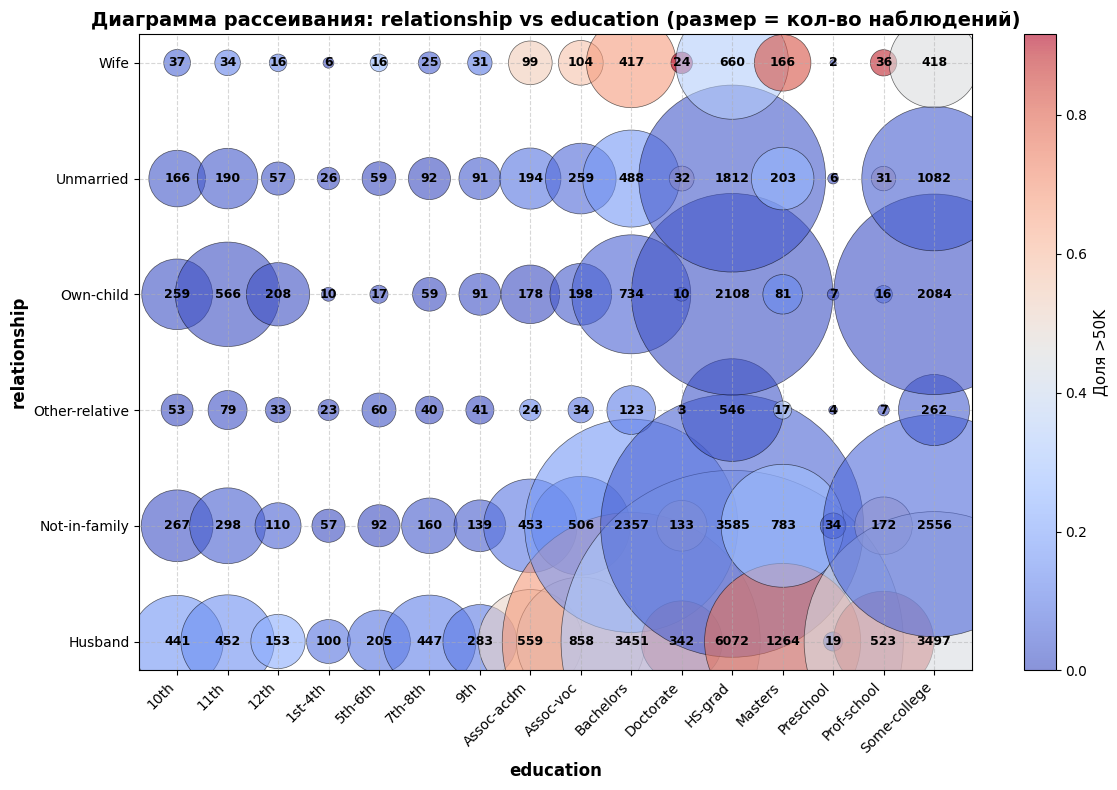

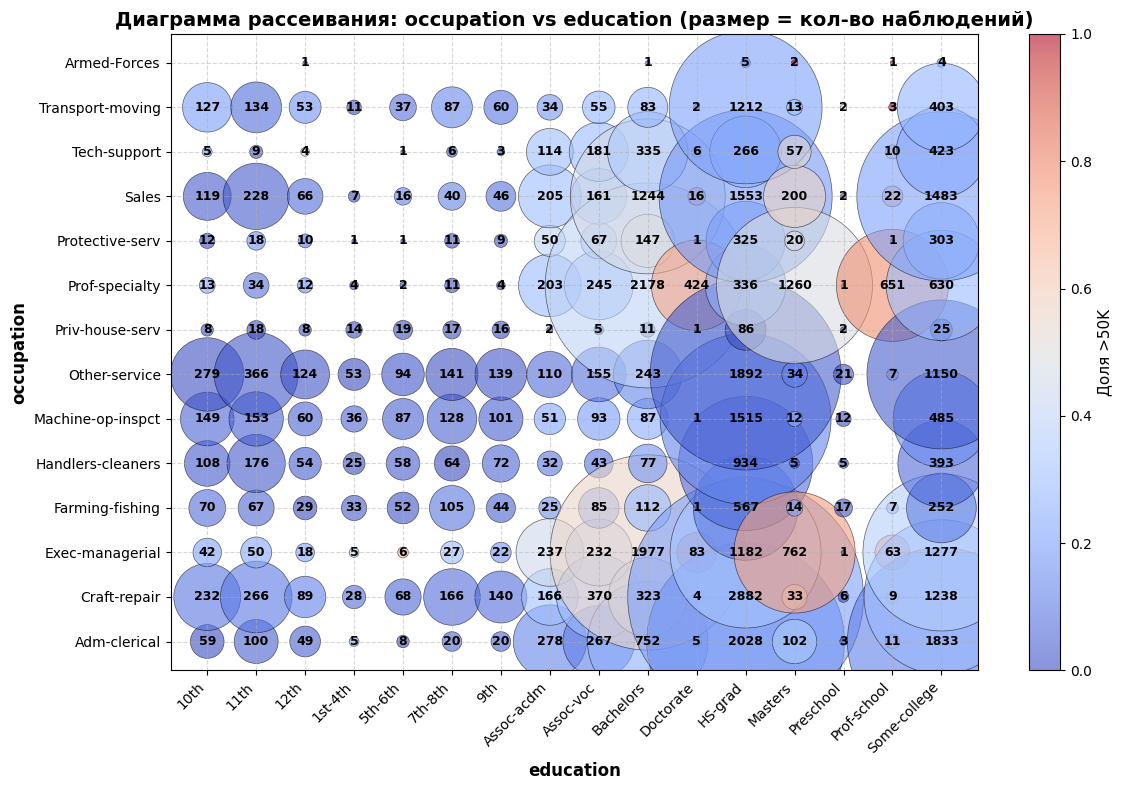

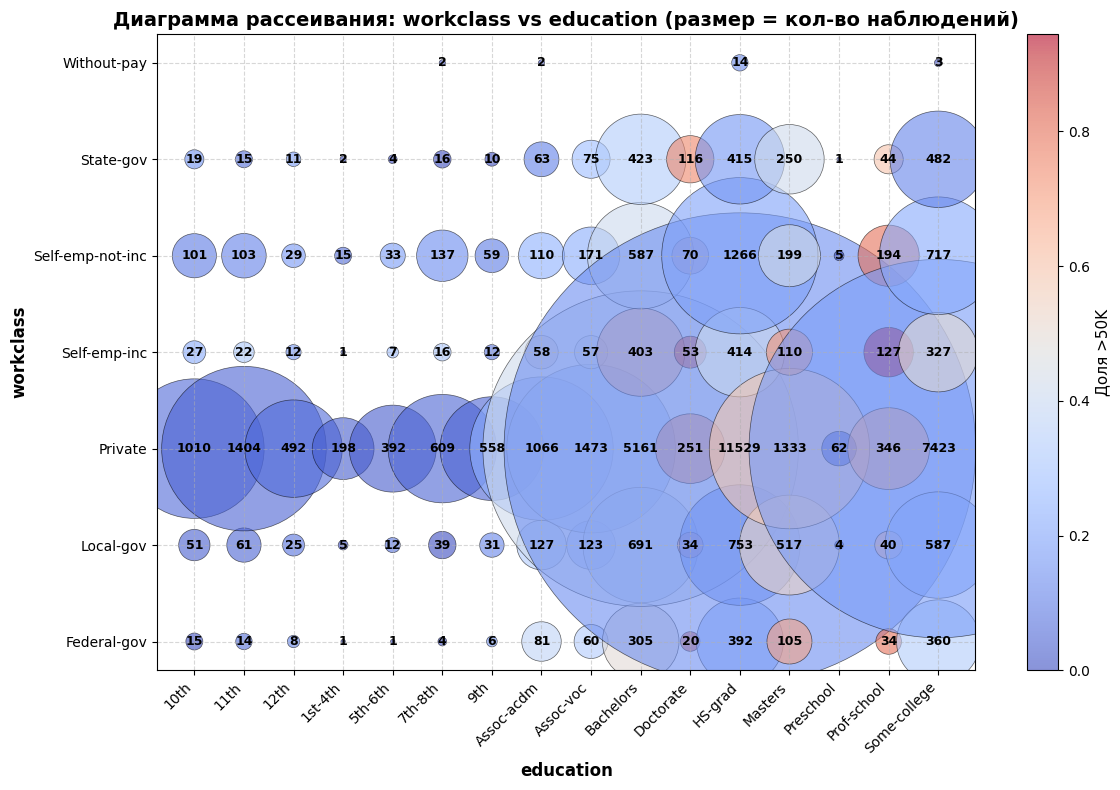

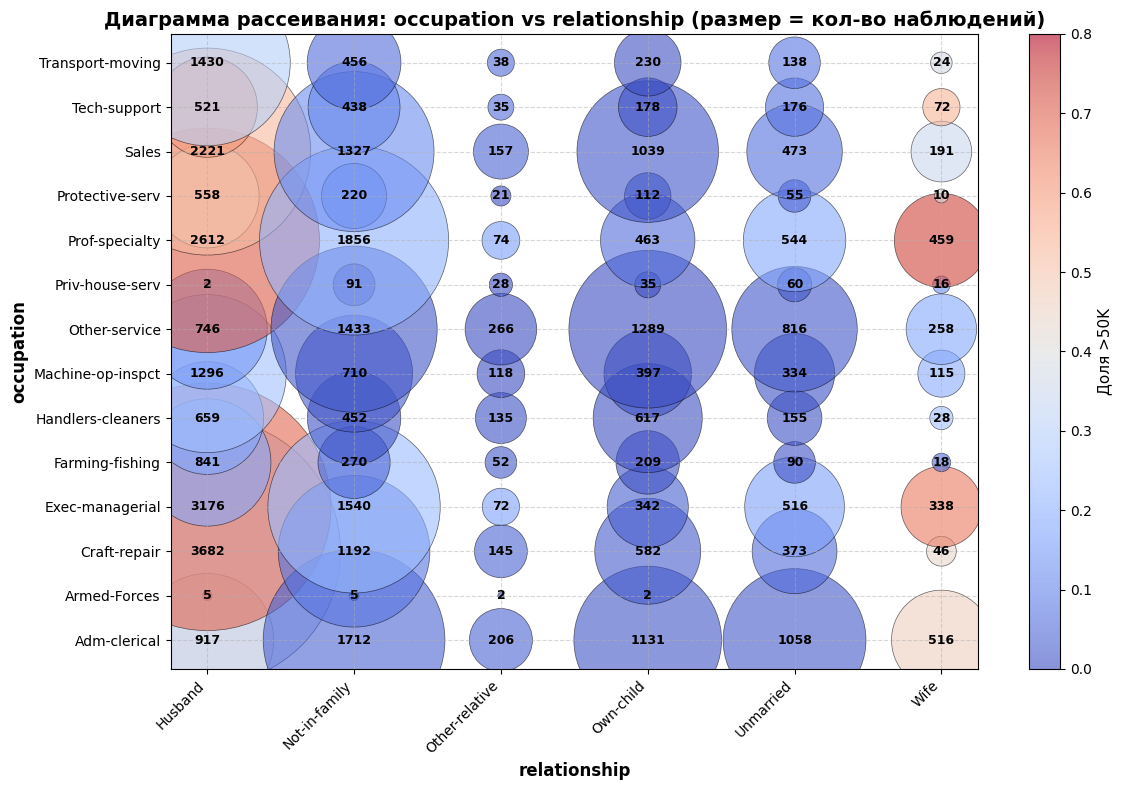

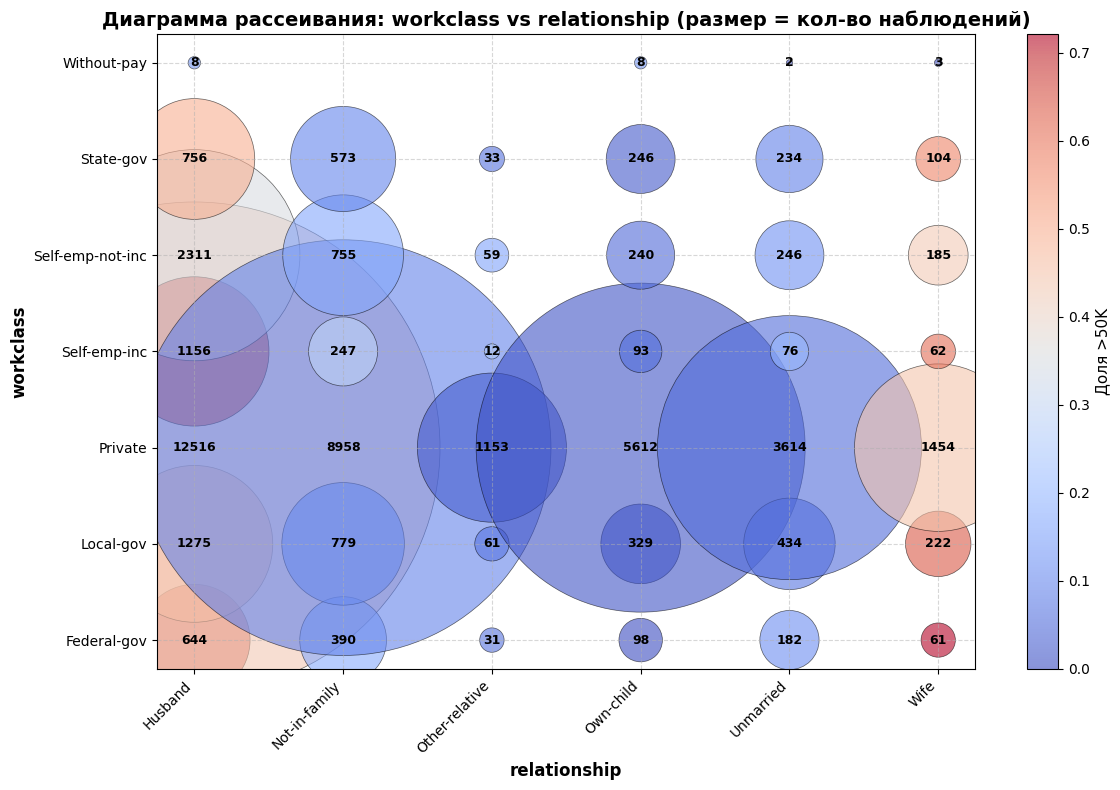

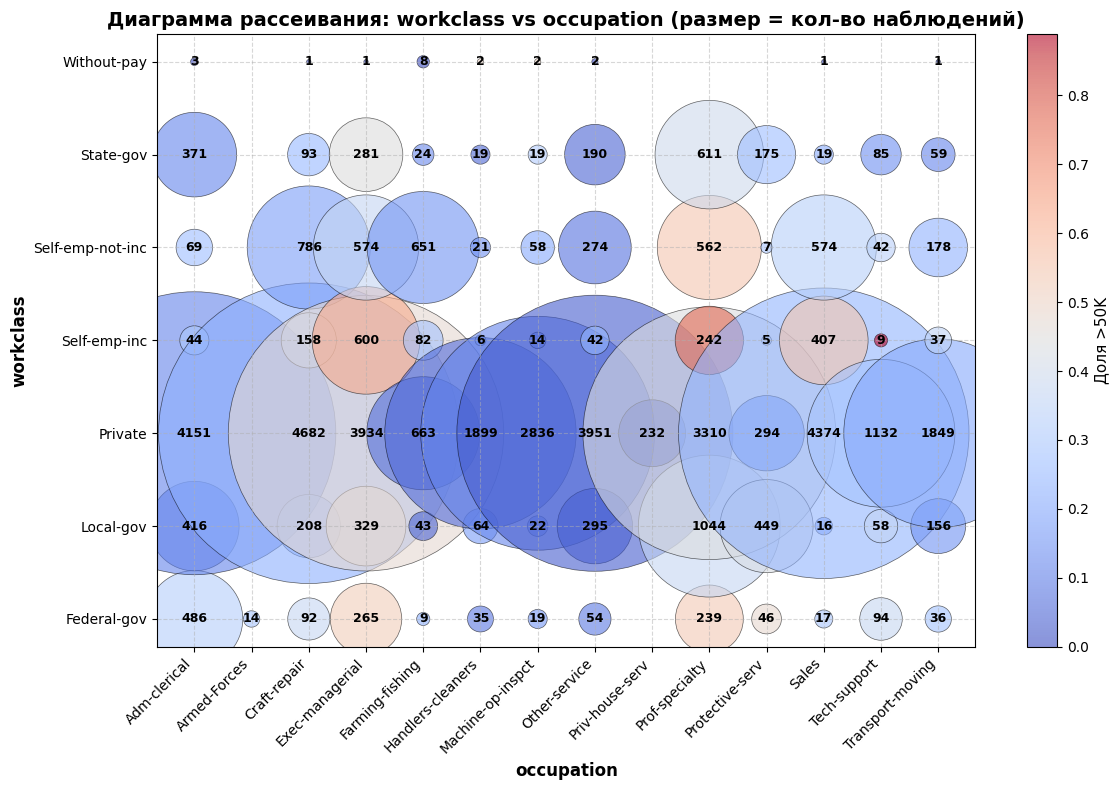

In [57]:
df_plot = df.copy()
df_plot['income_num'] = (df_plot['income'] == '>50K').astype(int)

categ_pairs = [
    ('education', 'relationship'),
    ('education', 'occupation'),
    ('education', 'workclass'),
    ('relationship', 'occupation'),
    ('relationship', 'workclass'),
    ('occupation', 'workclass'),
]

for x_col, y_col in categ_pairs:
    grouped = df_plot.groupby([x_col, y_col]).agg({
        'income_num': ['count', 'mean'] 
    }).reset_index()
    
    grouped.columns = [x_col, y_col, 'count', 'mean_income']
    plt.figure(figsize=(12, 8))
    sizes = grouped['count'] * 10 
    
    scatter = plt.scatter(
        grouped[x_col],
        grouped[y_col],
        c=grouped['mean_income'],  
        s=sizes,                   
        cmap='coolwarm',
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )
    
    for i in range(len(grouped)):
        plt.text(
            grouped.iloc[i][x_col],
            grouped.iloc[i][y_col],
            str(grouped.iloc[i]['count']),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=9,
            color='black',
            weight='bold'
        )

    plt.xlabel(x_col, fontsize=12, fontweight='bold')
    plt.ylabel(y_col, fontsize=12, fontweight='bold')
    plt.title(f'Диаграмма рассеивания: {y_col} vs {x_col} (размер = кол-во наблюдений)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Доля >50K', fontsize=11)
    plt.tight_layout()
    plt.show()

### Преобразование категориальных признаков в числовой формат

In [58]:
le_income = LabelEncoder()
le_relationship = LabelEncoder()
le_workclass = LabelEncoder()
le_education = LabelEncoder()
le_occupation = LabelEncoder()

df['income_num'] = le_income.fit_transform(df['income'])
df['relationship_num'] = le_relationship.fit_transform(df['relationship'])
df['workclass_num'] = le_workclass.fit_transform(df['workclass'])
df['education_num'] = le_education.fit_transform(df['education'])
df['occupation_num'] = le_occupation.fit_transform(df['occupation'])


columns_to_drop = ['fnlwgt', 'native-country', 
                    'marital-status', 
                   'race', 'gender', 
                   'income', 'relationship', 'workclass', 'education', 'occupation']
df = df.drop(columns=columns_to_drop)

print("Столбцы после удаления:")
print(df.columns.tolist())

Столбцы после удаления:
['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income_num', 'relationship_num', 'workclass_num', 'education_num', 'occupation_num']


### Дерево решений

=== Метрики для обучающего множества ===
Accuracy: 0.8651
Precision (macro): 0.8178
Precision (micro): 0.8651
Recall (macro): 0.8842
Recall (micro): 0.8651
F1-score (macro): 0.8385
F1-score (micro): 0.8651
AUC: 0.9606
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.8101
Precision (macro): 0.7527
Precision (micro): 0.8101
Recall (macro): 0.8049
Recall (micro): 0.8101
F1-score (macro): 0.7687
F1-score (micro): 0.8101
AUC: 0.8676
------------------------------


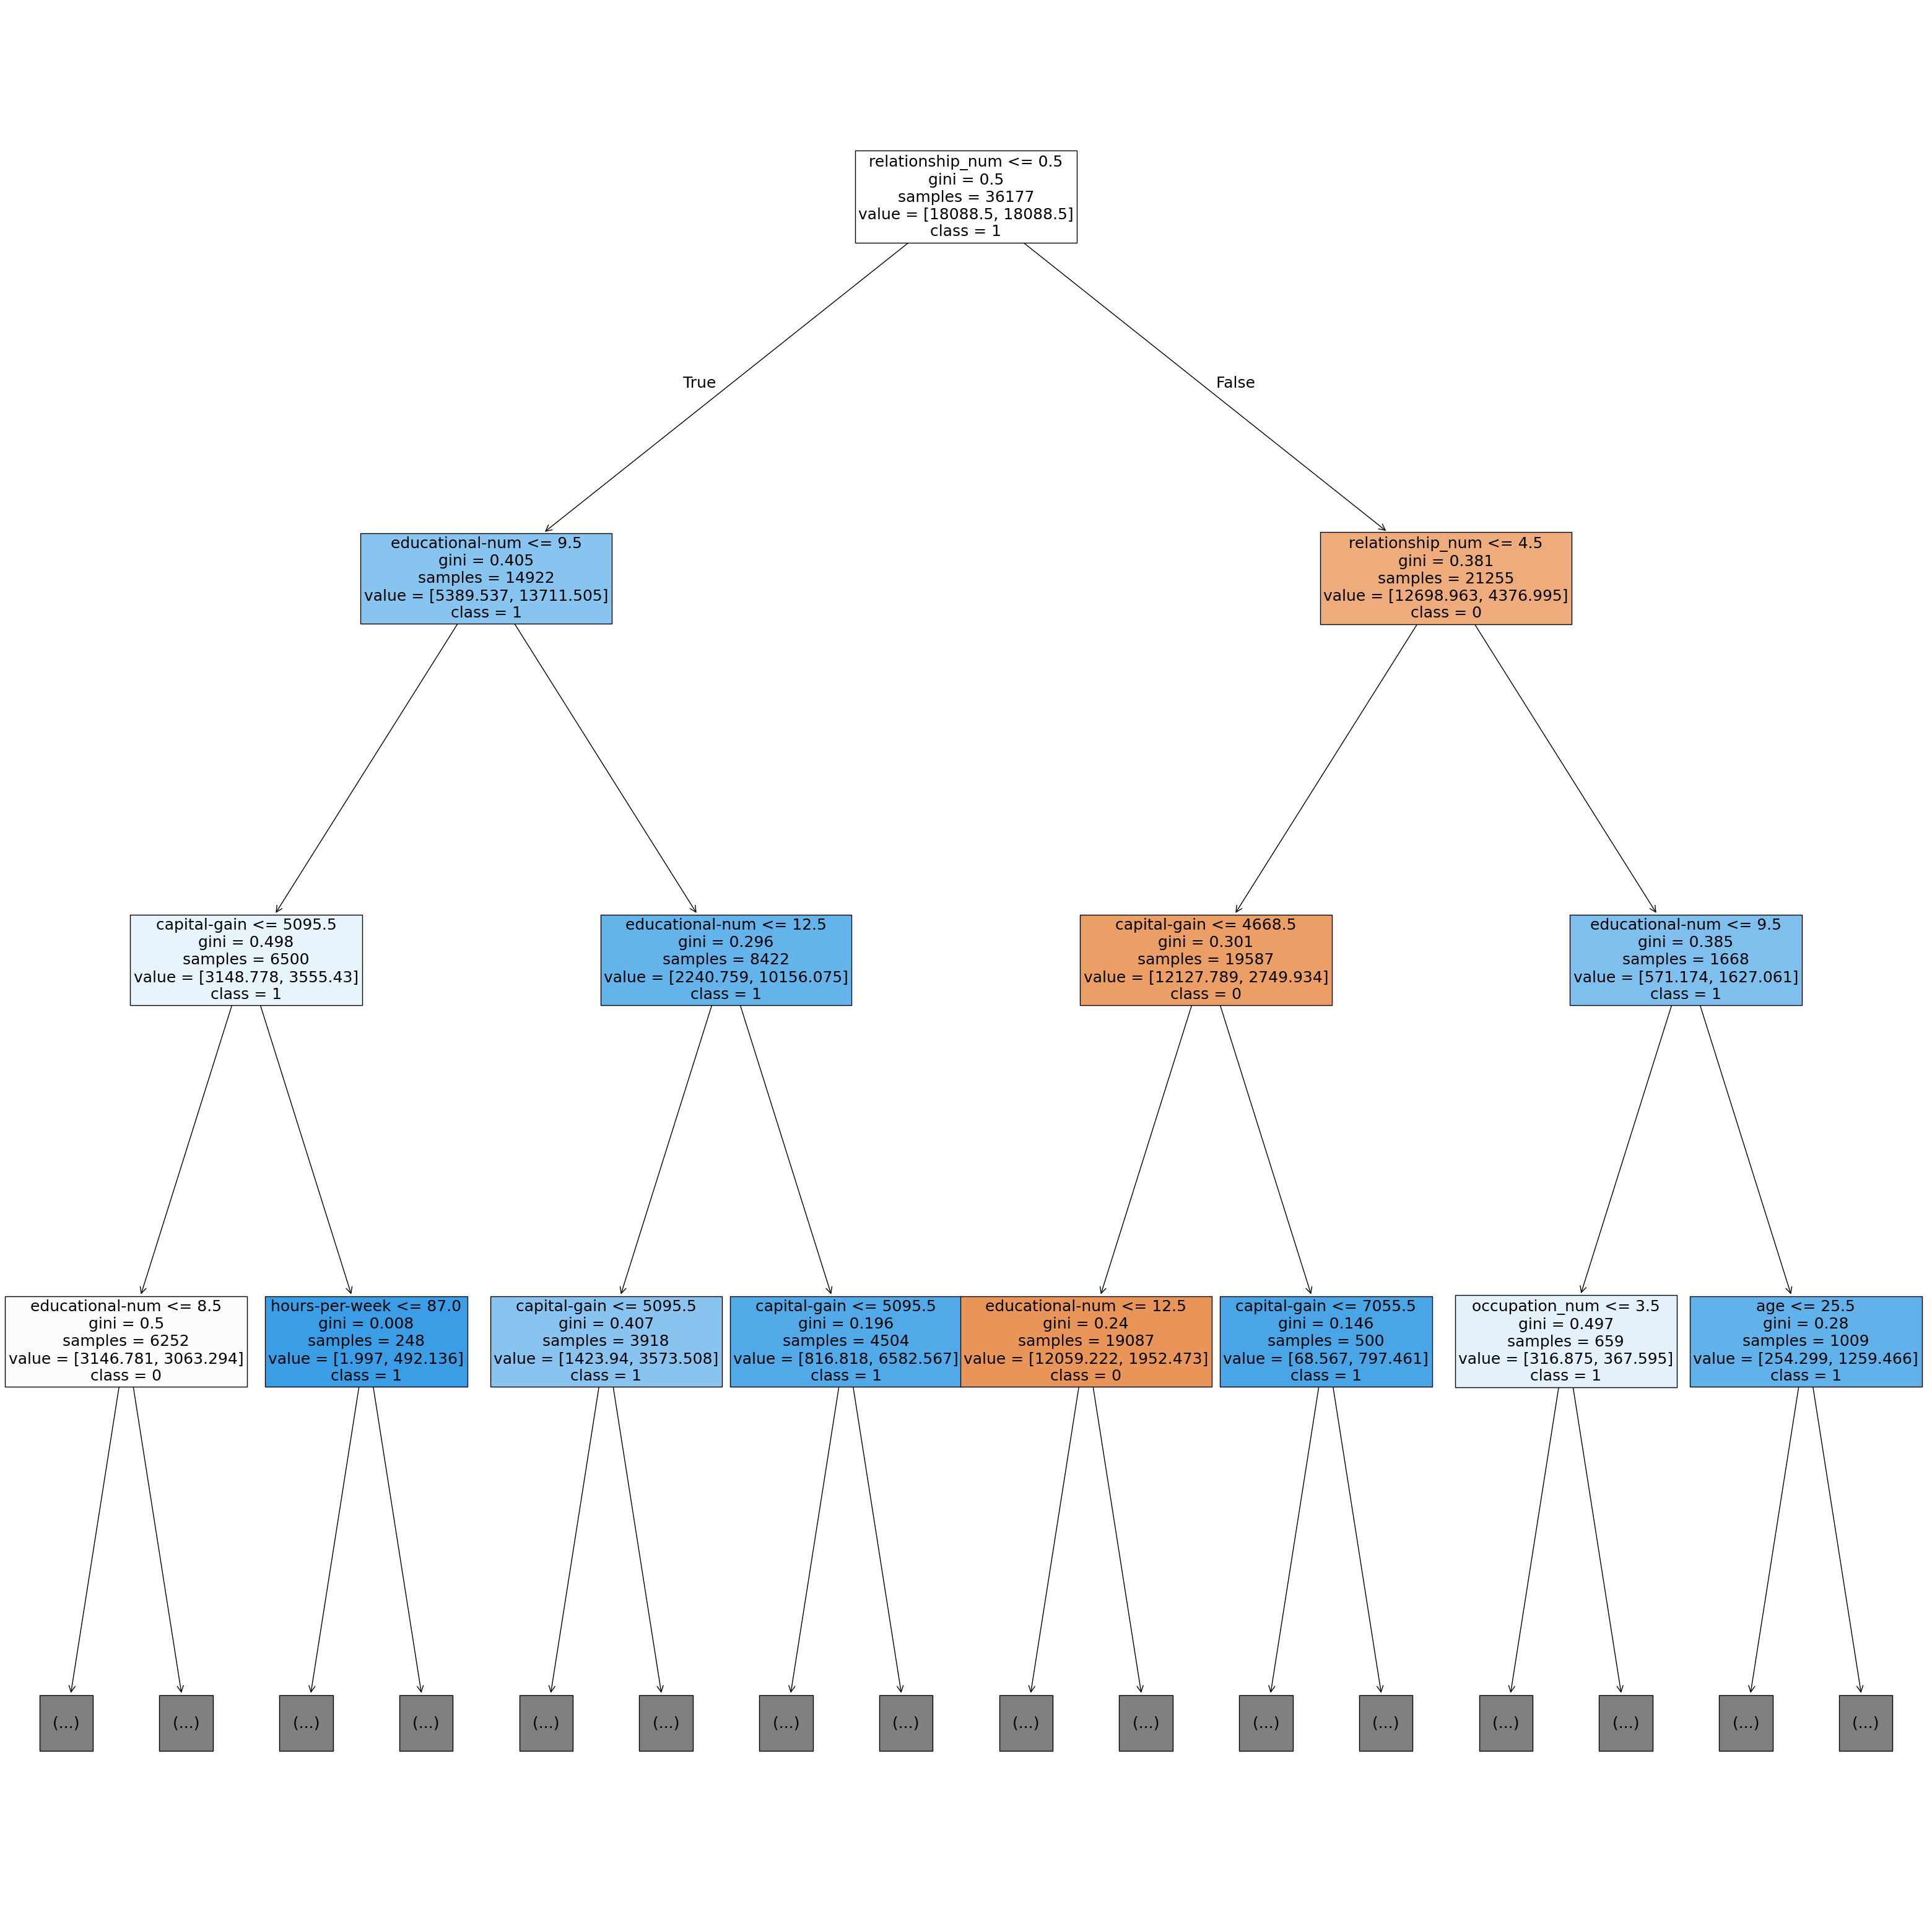

In [59]:
X = df.drop('income_num', axis=1)
y = df['income_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    min_samples_split=10,  
    min_samples_leaf=5,    
    criterion='gini'       
)

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
y_train_proba = clf.predict_proba(X_train)[:, 1]
y_test_proba = clf.predict_proba(X_test)[:, 1]

def calculate_metrics(y_true, y_pred, y_proba, dataset_name):
    print(f"=== Метрики для {dataset_name} ===")
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    auc = roc_auc_score(y_true, y_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Precision (micro): {precision_micro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"Recall (micro): {recall_micro:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"F1-score (micro): {f1_micro:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 30)

calculate_metrics(y_train, y_train_pred, y_train_proba, "обучающего множества")
calculate_metrics(y_test, y_test_pred, y_test_proba, "тестового множества")

plt.figure(figsize=(40, 40))
plot_tree(clf,
          filled=True,
          fontsize=18,
          max_depth=3,
          feature_names=X.columns,
          class_names=clf.classes_.astype(str),  
          )
plt.show()

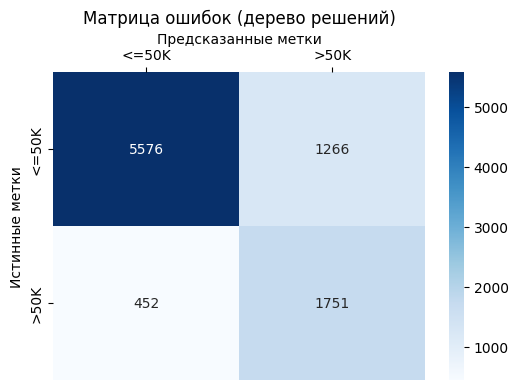

In [60]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_income.classes_, yticklabels=le_income.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (дерево решений)')
plt.show()

### Метод нейронной сети

Сеть, определённая с помощью Sequential и состоящая из слоёв Dense, характерна для полносвязной архитектуры:

Каждый нейрон в слое Dense(64, ...) соединён со всеми нейронами предыдущего слоя (в данном случае — с выходами предыдущего слоя признаков после preprocessor).
Каждый нейрон в слое Dense(32, ...) соединён со всеми нейронами предыдущего слоя (Dense(64, ...)).
Наконец, выходной слой Dense(1, ...) также соединён со всеми нейронами предыдущего слоя (Dense(32, ...)).
Слои Dropout не изменяют архитектуру на "разреженную" — они просто случайным образом "отключают" часть нейронов во время обучения для борьбы с переобучением, но структура полносвязности сохраняется.

c:\Документы\НГТУ\7 семестр\Методы анализа данных\лабы\МАД лаба 2\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


=== Метрики для обучающего множества (Нейронная сеть) ===
Accuracy: 0.8600
Precision (macro): 0.8237
Precision (micro): 0.8600
Recall (macro): 0.7857
Recall (micro): 0.8600
F1-score (macro): 0.8016
F1-score (micro): 0.8600
AUC: 0.9178
----------------------------------------
=== Метрики для тестового множества (Нейронная сеть) ===
Accuracy: 0.8564
Precision (macro): 0.8170
Precision (micro): 0.8564
Recall (macro): 0.7738
Recall (micro): 0.8564
F1-score (macro): 0.7915
F1-score (micro): 0.8564
AUC: 0.9096
----------------------------------------


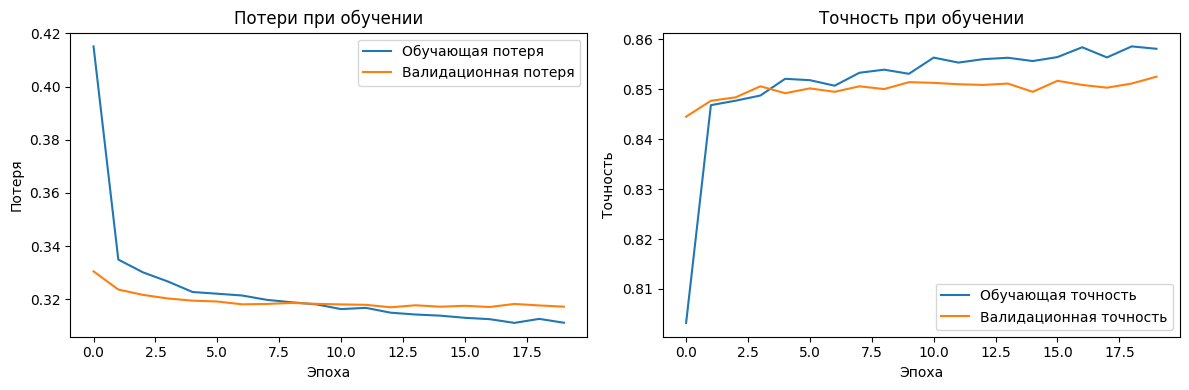

In [ ]:
X = df.drop('income_num', axis=1)  
y = df['income_num']

numeric_columns = ['age', 'hours-per-week', 'capital-gain', 
                   'capital-loss', 'educational-num']
all_columns = X.columns.tolist() 
categorical_columns = [col for col in all_columns if col not in numeric_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

X_processed = preprocessor.fit_transform(X)
X_processed = X_processed.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)), # relu - функция активации, применяемая к выходу слоя
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # sigmoid - функция активации, которая преобразует выход в диапазон [0, 1] (вероятность принадлежности к положительному классу)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # adam - алгоритм градиентного спуска, который адаптивно подбирает скорость обучения

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=0 
)

y_train_proba_raw = model.predict(X_train, verbose=0)
y_test_proba_raw = model.predict(X_test, verbose=0)

y_train_pred = (y_train_proba_raw > 0.5).astype(int)
y_test_pred = (y_test_proba_raw > 0.5).astype(int)

y_train_proba = y_train_proba_raw.flatten()
y_test_proba = y_test_proba_raw.flatten()

def calculate_metrics_n(y_true, y_pred, y_proba, dataset_name):
    print(f"=== Метрики для {dataset_name} (Нейронная сеть) ===")
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    auc = roc_auc_score(y_true, y_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Precision (micro): {precision_micro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"Recall (micro): {recall_micro:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"F1-score (micro): {f1_micro:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 40)

calculate_metrics_n(y_train, y_train_pred, y_train_proba, "обучающего множества")
calculate_metrics_n(y_test, y_test_pred, y_test_proba, "тестового множества")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучающая потеря')
plt.plot(history.history['val_loss'], label='Валидационная потеря')
plt.title('Потери при обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Обучающая точность')
plt.plot(history.history['val_accuracy'], label='Валидационная точность')
plt.title('Точность при обучении')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

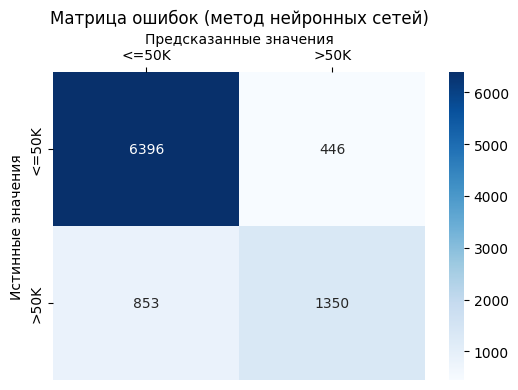

In [62]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xticks(rotation=0) 
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок (метод нейронных сетей)')
plt.show()

### Оценка значимости признаков для дерева решения

In [63]:
feature_importances = clf.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)[::-1]
print("Значимость признаков:")
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")

Значимость признаков:
relationship_num: 0.4100
educational-num: 0.1360
age: 0.1291
capital-gain: 0.1286
hours-per-week: 0.0713
occupation_num: 0.0577
capital-loss: 0.0361
workclass_num: 0.0234
education_num: 0.0079


### Оценка значимости признаков для нейронной сети (пермутационная значимость)

In [64]:
model = Ridge().fit(X_train, y_train)
result = permutation_importance(
    estimator=model, X=X_test, y=y_test, n_repeats=3, random_state=42
)

sorted_idx = result.importances_mean.argsort()[::-1]

encoded_feature_names = (
    numeric_columns +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns))
)
print(f"Количество признаков после кодирования: {len(encoded_feature_names)}")

for idx in sorted_idx:
    print(f"{encoded_feature_names[idx]}: {result.importances_mean[idx]:.4f} +/- {result.importances_std[idx]:.3f}")

Количество признаков после кодирования: 48
relationship_num_0: 0.0898 +/- 0.005
educational-num: 0.0548 +/- 0.002
capital-gain: 0.0340 +/- 0.001
relationship_num_1: 0.0327 +/- 0.003
relationship_num_5: 0.0317 +/- 0.002
occupation_num_3: 0.0165 +/- 0.001
relationship_num_4: 0.0148 +/- 0.001
age: 0.0145 +/- 0.001
capital-loss: 0.0126 +/- 0.000
relationship_num_3: 0.0123 +/- 0.000
hours-per-week: 0.0119 +/- 0.000
education_num_11: 0.0076 +/- 0.001
occupation_num_9: 0.0048 +/- 0.001
occupation_num_4: 0.0041 +/- 0.001
workclass_num_4: 0.0035 +/- 0.000
education_num_15: 0.0034 +/- 0.000
workclass_num_0: 0.0025 +/- 0.000
workclass_num_3: 0.0020 +/- 0.000
education_num_7: 0.0020 +/- 0.000
relationship_num_2: 0.0016 +/- 0.001
education_num_14: 0.0014 +/- 0.000
occupation_num_6: 0.0013 +/- 0.000
occupation_num_11: 0.0013 +/- 0.001
workclass_num_2: 0.0012 +/- 0.000
occupation_num_7: 0.0010 +/- 0.000
occupation_num_10: 0.0009 +/- 0.000
occupation_num_12: 0.0009 +/- 0.001
occupation_num_13: 0.0008 

### Изменение параметра одного из методов

min_samples_leaf=1

=== Метрики для обучающего множества ===
Accuracy: 0.8888
Precision (macro): 0.8436
Precision (micro): 0.8888
Recall (macro): 0.9116
Recall (micro): 0.8888
F1-score (macro): 0.8660
F1-score (micro): 0.8888
AUC: 0.9760
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.7977
Precision (macro): 0.7356
Precision (micro): 0.7977
Recall (macro): 0.7776
Recall (micro): 0.7977
F1-score (macro): 0.7497
F1-score (micro): 0.7977
AUC: 0.8257
------------------------------


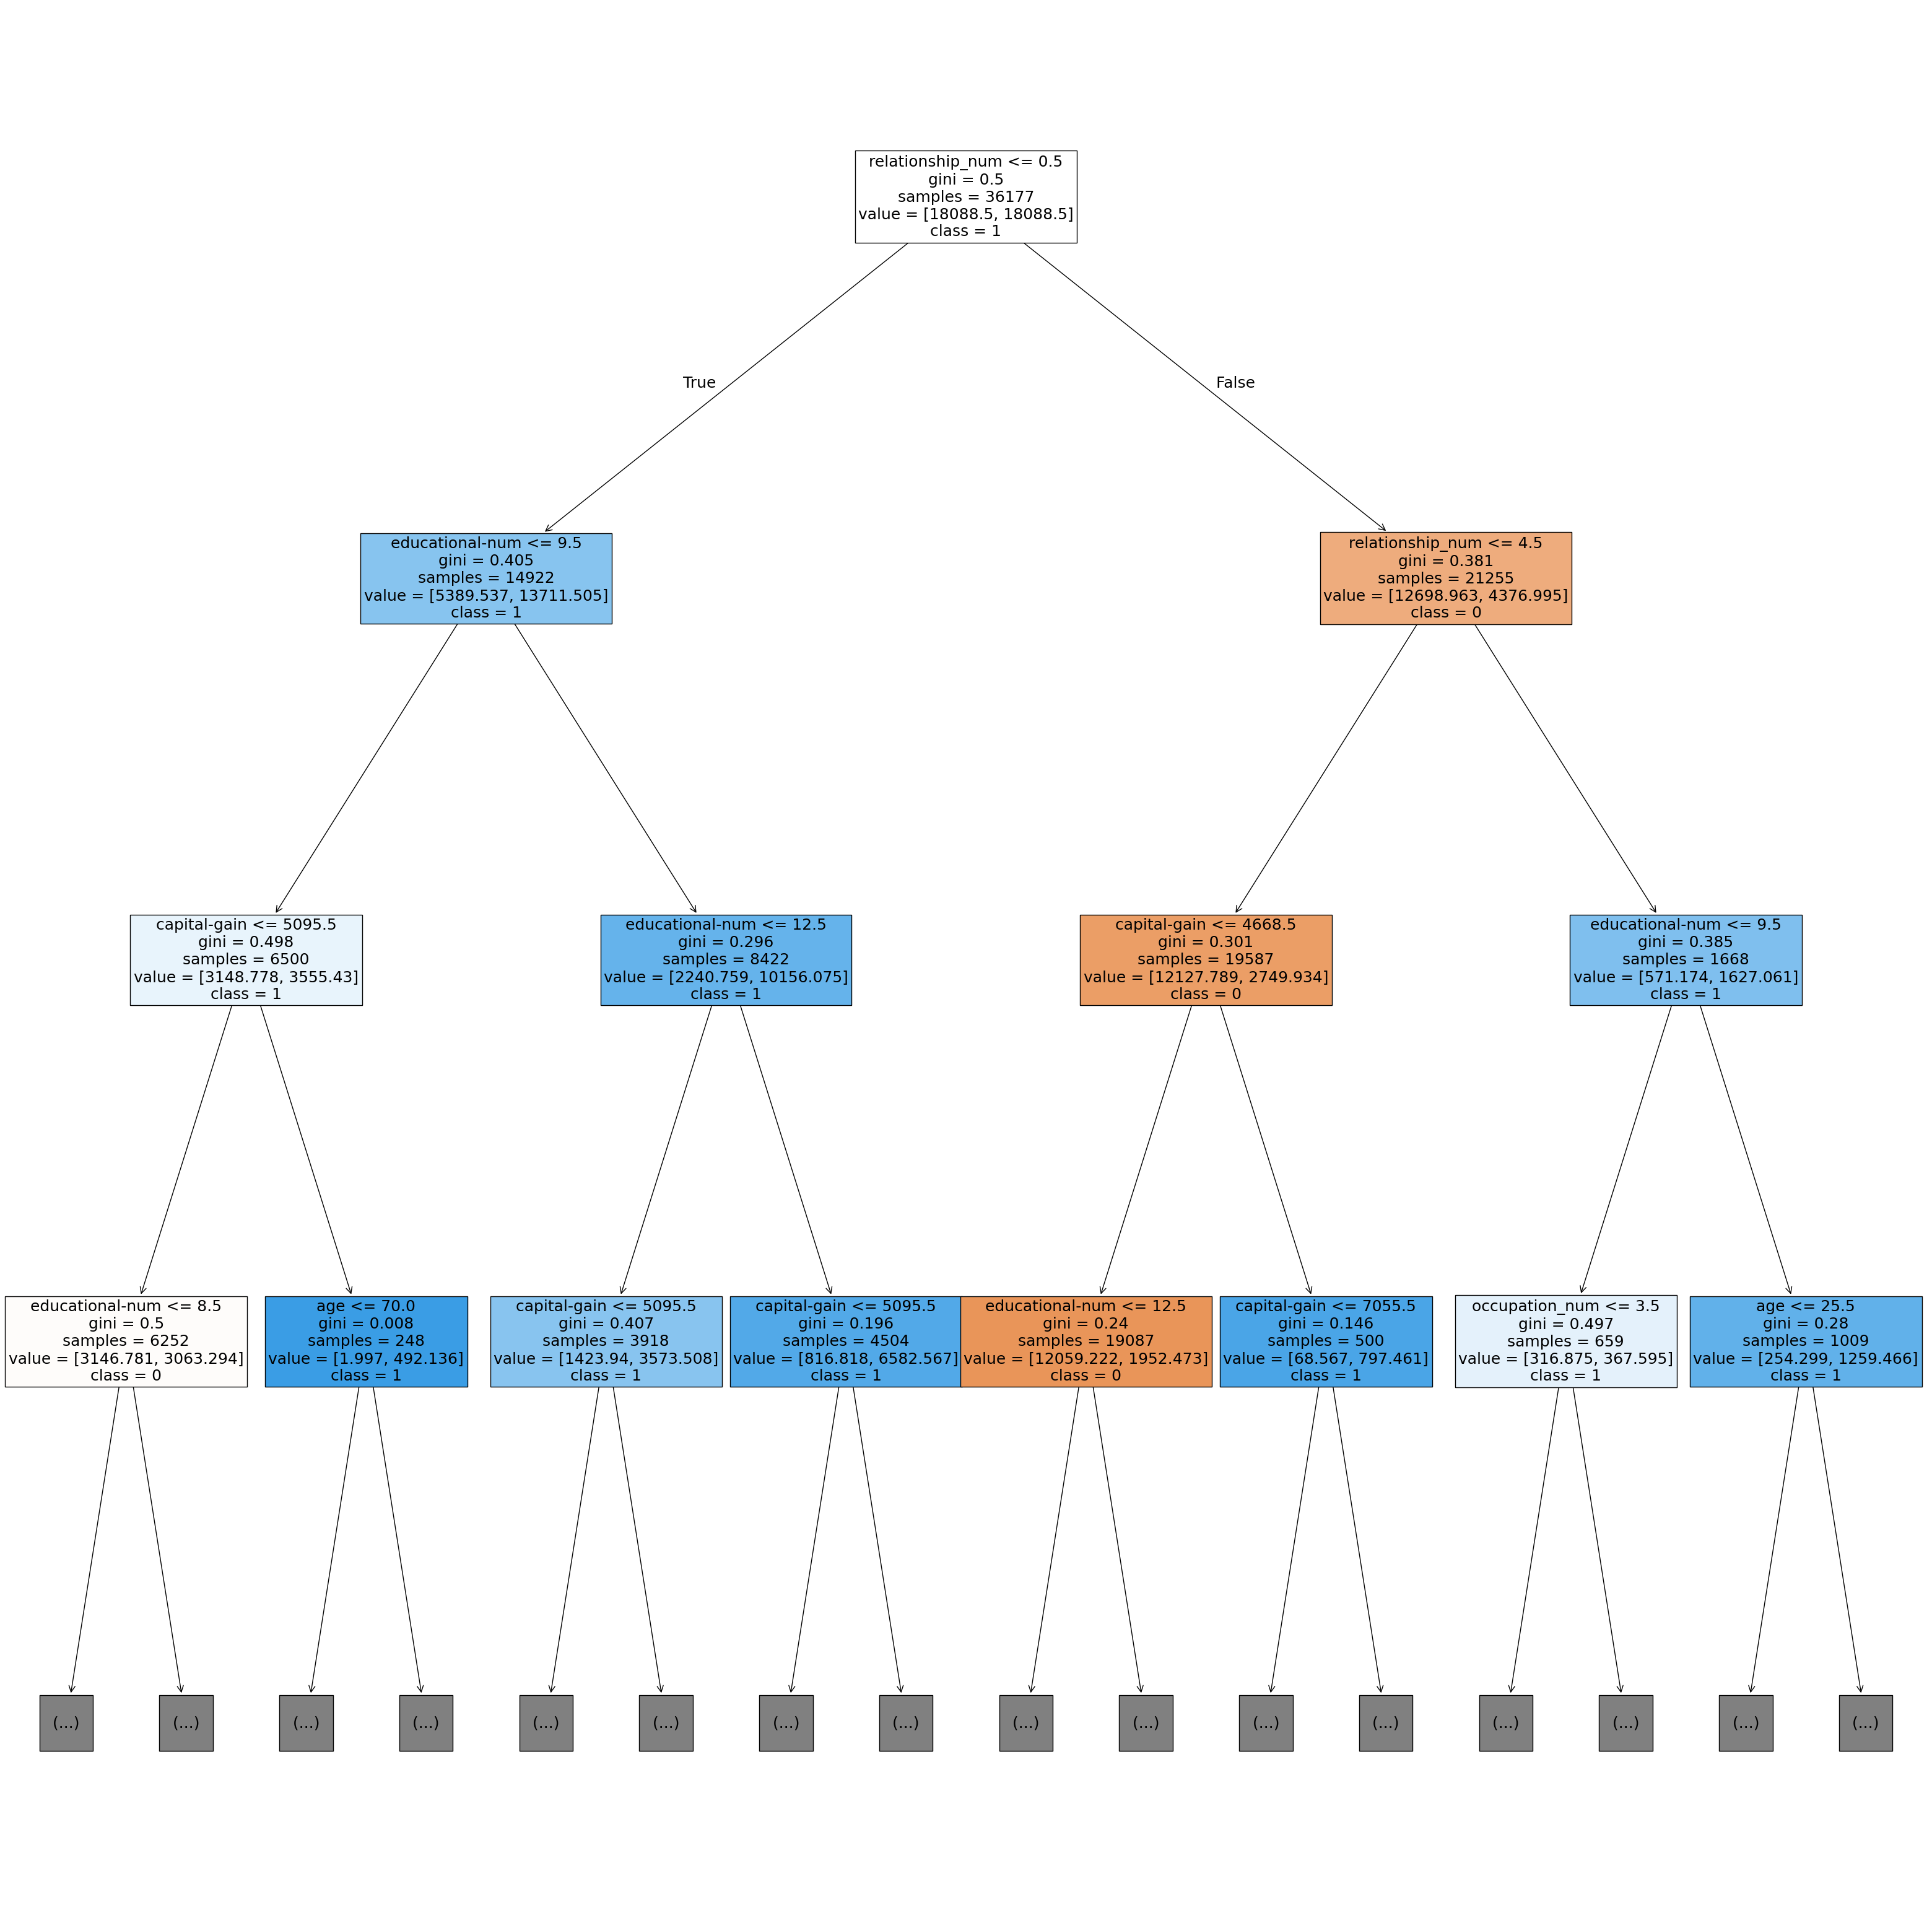

In [65]:
X = df.drop('income_num', axis=1) 
y = df['income_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    min_samples_split=10,  
    min_samples_leaf=1,    
    criterion='gini'       
)

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

y_train_proba = clf.predict_proba(X_train)[:, 1]
y_test_proba = clf.predict_proba(X_test)[:, 1]

calculate_metrics(y_train, y_train_pred, y_train_proba, "обучающего множества")
calculate_metrics(y_test, y_test_pred, y_test_proba, "тестового множества")

plt.figure(figsize=(40, 40))
plot_tree(clf,
          filled=True,
          fontsize=18,
          max_depth=3,
          feature_names=X.columns,
          class_names=clf.classes_.astype(str),  
          )
plt.show()

min_samples_leaf=10

=== Метрики для обучающего множества ===
Accuracy: 0.8433
Precision (macro): 0.7956
Precision (micro): 0.8433
Recall (macro): 0.8627
Recall (micro): 0.8433
F1-score (macro): 0.8144
F1-score (micro): 0.8433
AUC: 0.9456
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.8035
Precision (macro): 0.7484
Precision (micro): 0.8035
Recall (macro): 0.8057
Recall (micro): 0.8035
F1-score (macro): 0.7641
F1-score (micro): 0.8035
AUC: 0.8871
------------------------------


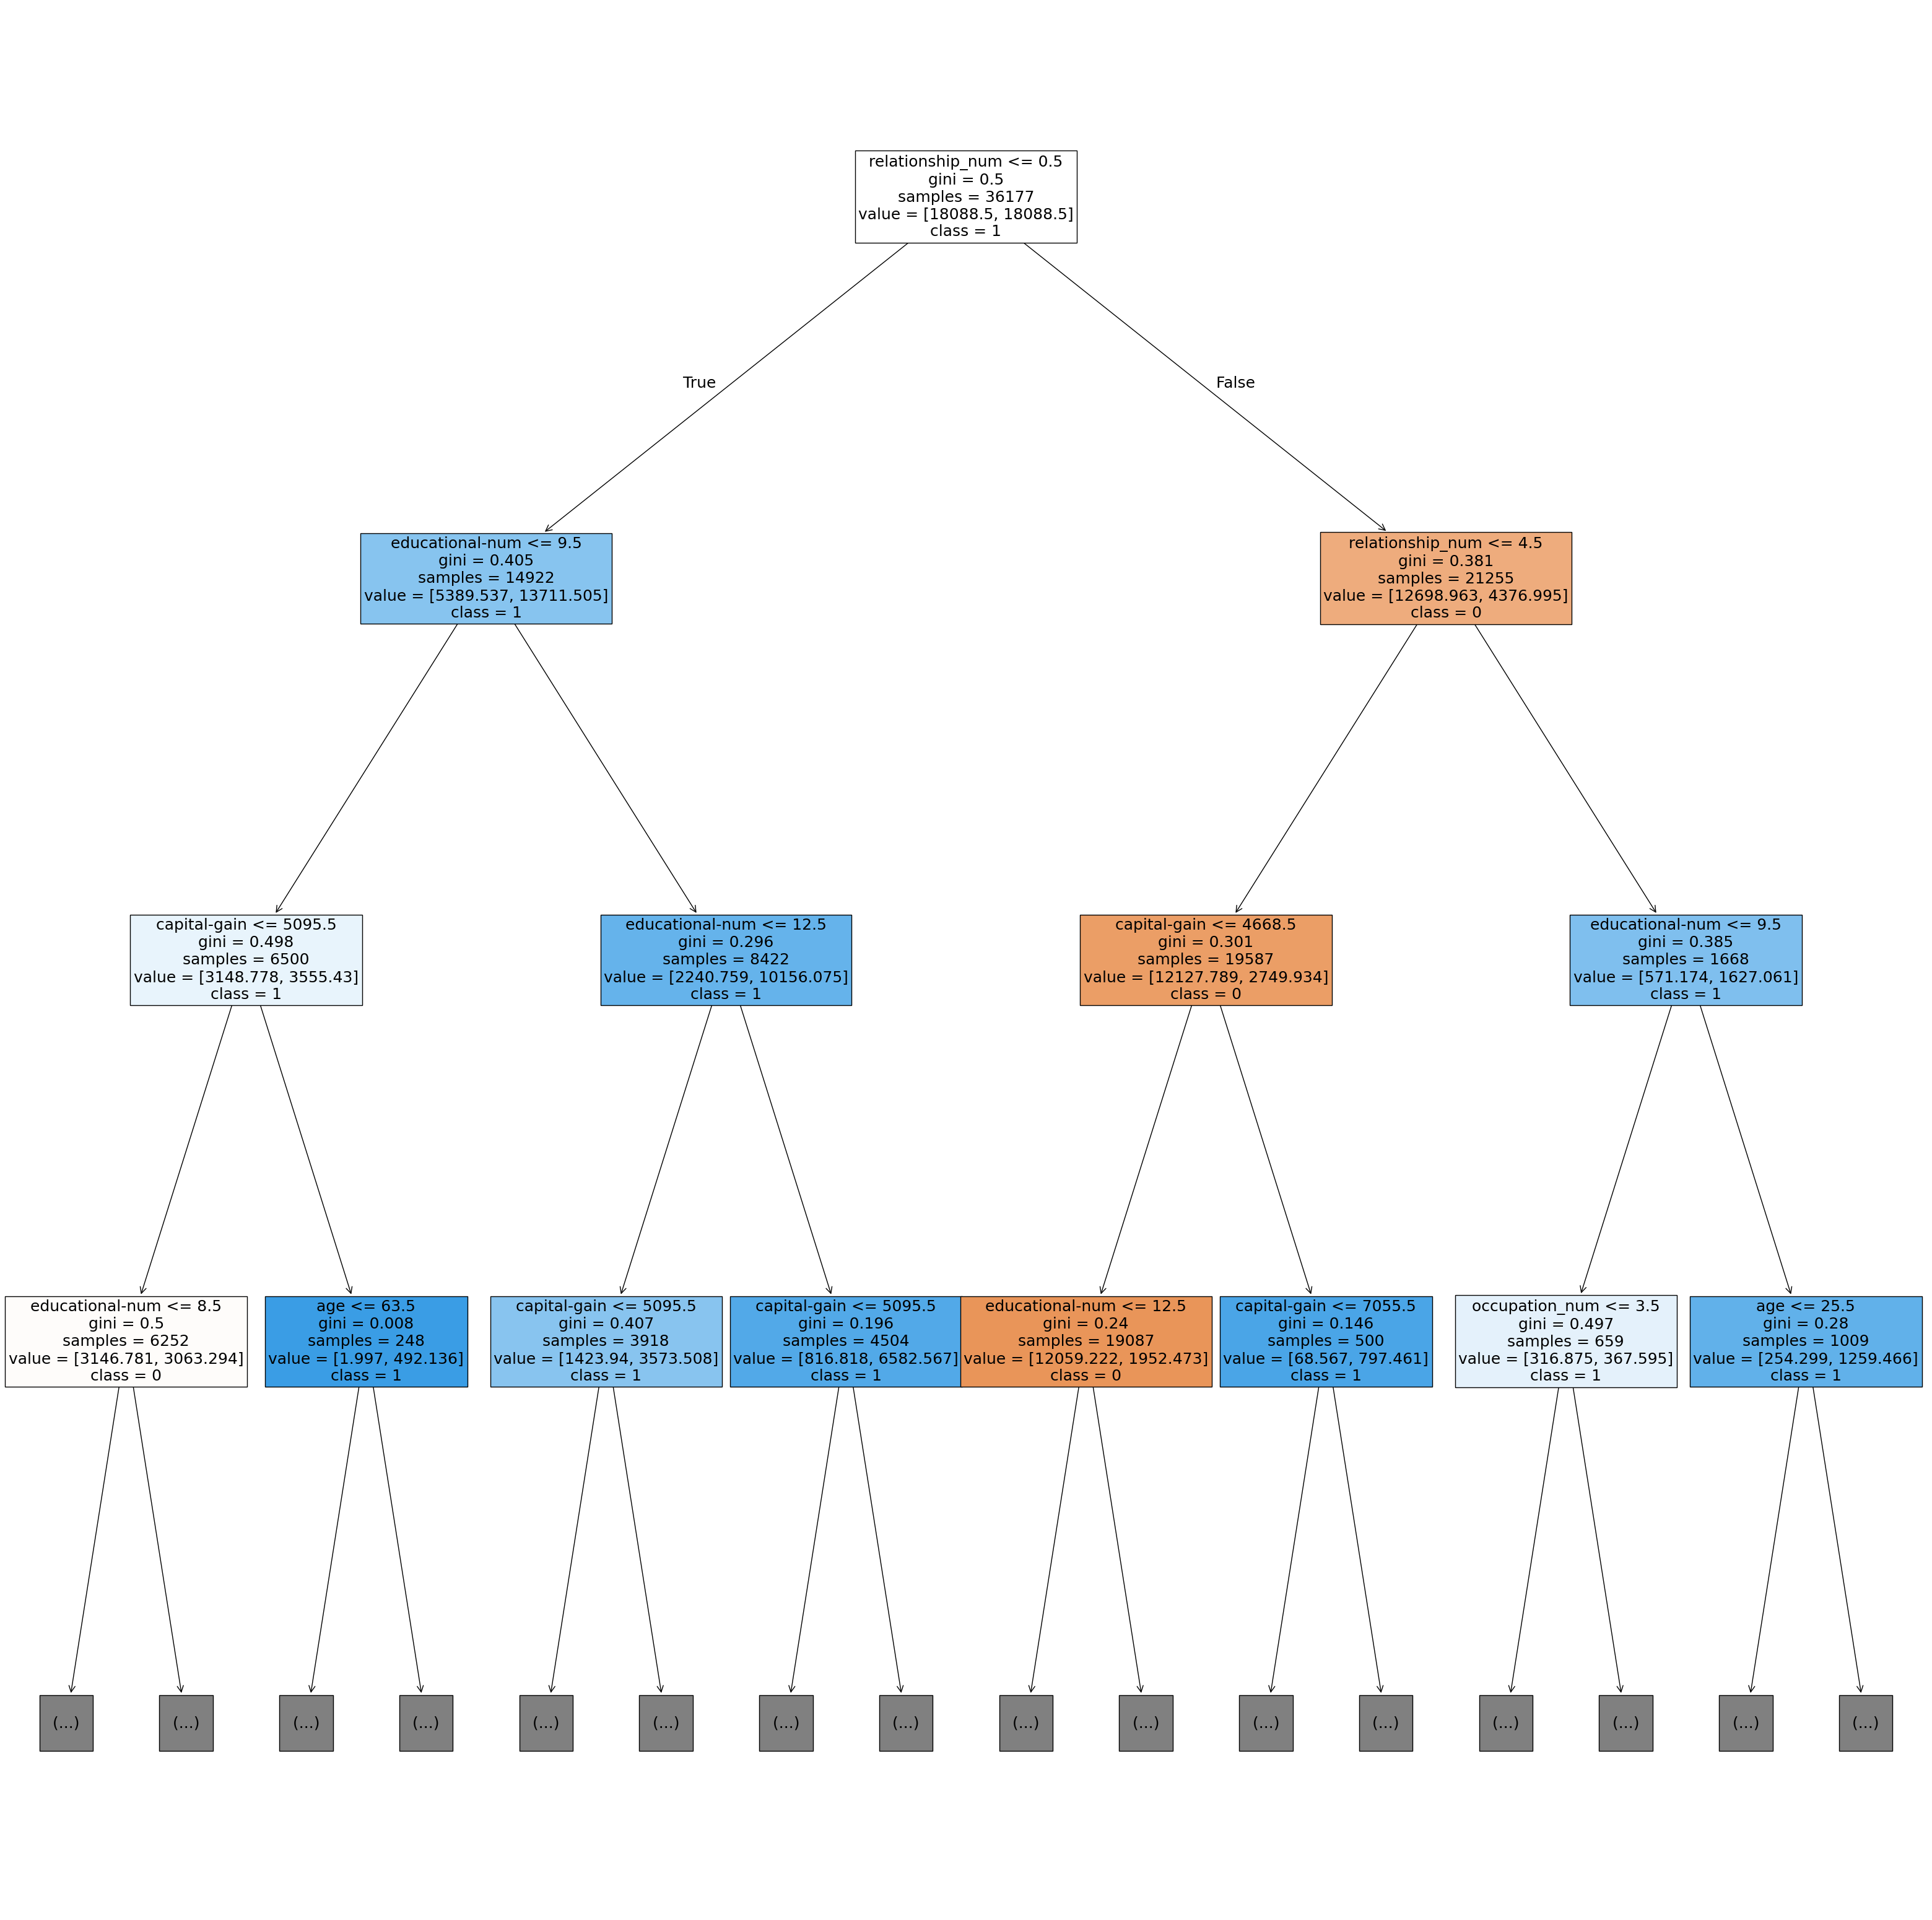

In [66]:
X = df.drop('income_num', axis=1)
y = df['income_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    min_samples_split=10,
    min_samples_leaf=10, 
    criterion='gini'       
)

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

y_train_proba = clf.predict_proba(X_train)[:, 1]
y_test_proba = clf.predict_proba(X_test)[:, 1]

calculate_metrics(y_train, y_train_pred, y_train_proba, "обучающего множества")
calculate_metrics(y_test, y_test_pred, y_test_proba, "тестового множества")

plt.figure(figsize=(40, 40))
plot_tree(clf,
          filled=True,
          fontsize=18,
          max_depth=3,
          feature_names=X.columns,
          class_names=clf.classes_.astype(str),  
          )
plt.show()

### Удаление малозначимых признаков для дерева решений

Значения метрик при значимых признаках
=== Метрики для обучающего множества ===
Accuracy: 0.8499
Precision (macro): 0.8034
Precision (micro): 0.8499
Recall (macro): 0.8740
Recall (micro): 0.8499
F1-score (macro): 0.8228
F1-score (micro): 0.8499
AUC: 0.9526
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.7879
Precision (macro): 0.7338
Precision (micro): 0.7879
Recall (macro): 0.7915
Recall (micro): 0.7879
F1-score (macro): 0.7478
F1-score (micro): 0.7879
AUC: 0.8614
------------------------------


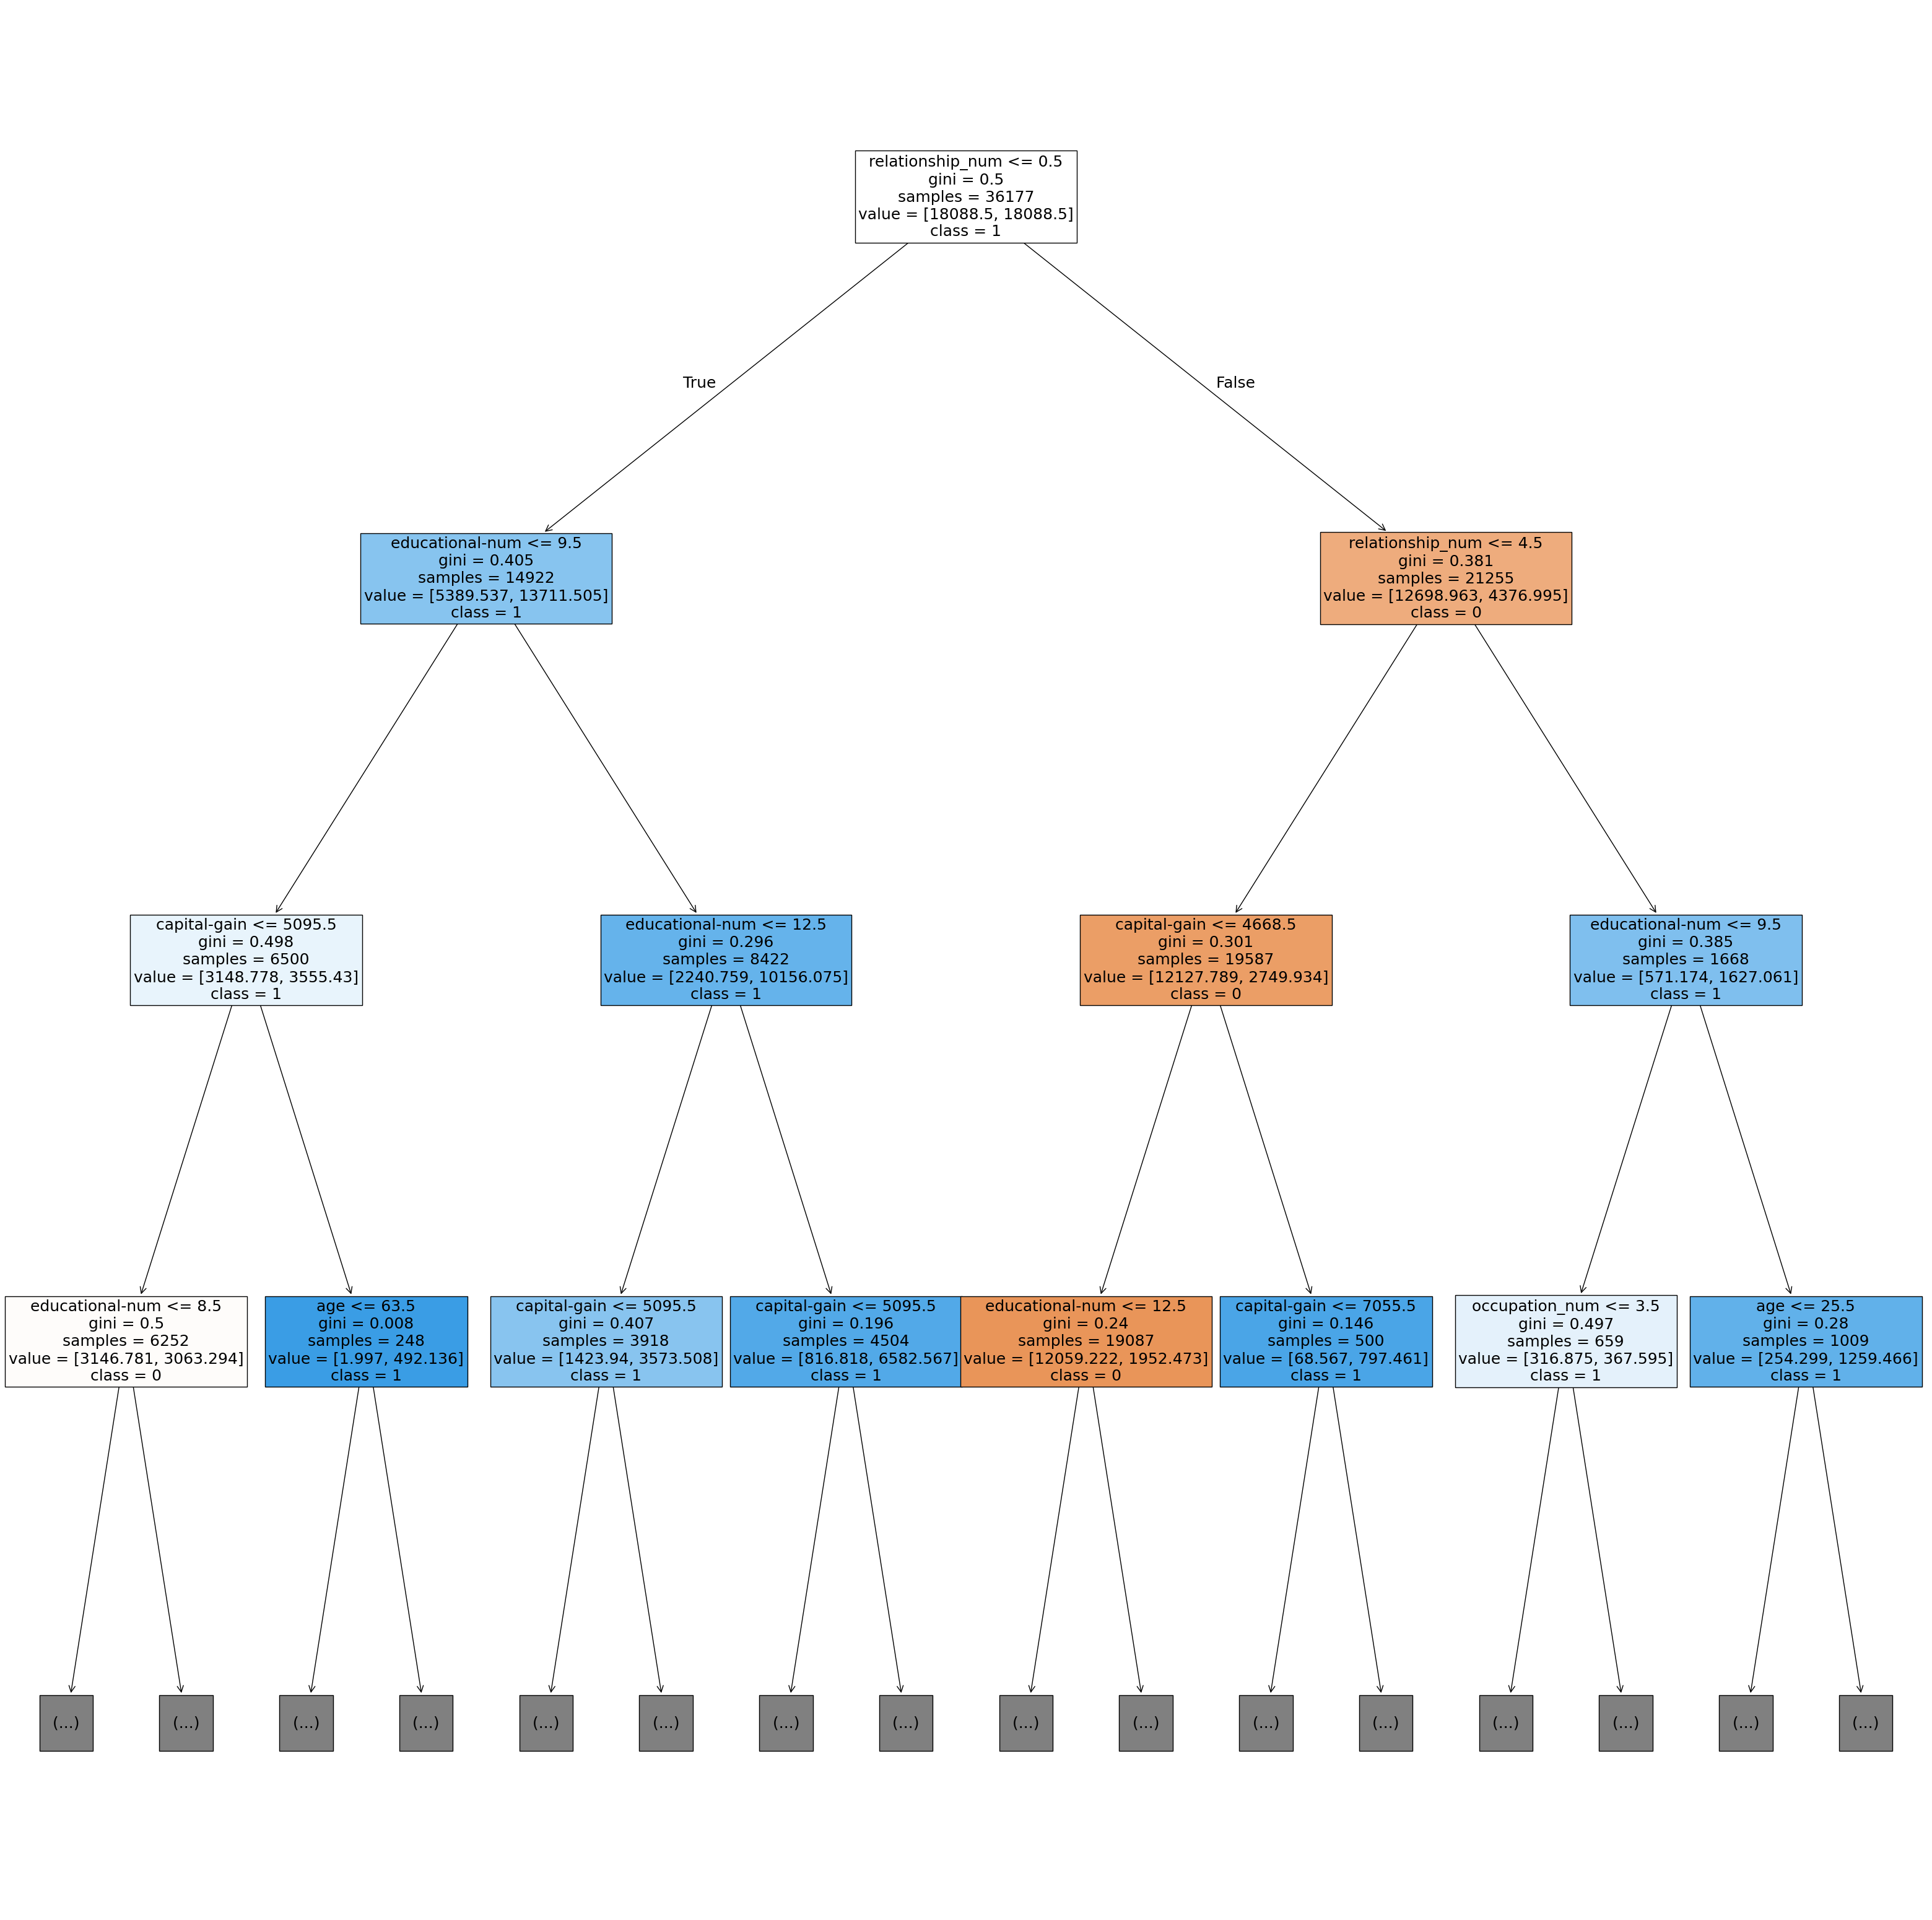

In [ ]:
threshold = 0.05
significant_features = [feature_names[i] for i in range(len(feature_importances)) if feature_importances[i] > threshold]
X_significant = X[significant_features]

X_train_sig, X_test_sig, y_train, y_test = train_test_split(X_significant, y, test_size=0.2, random_state=42)

clf_sig = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='gini'
)
clf_sig.fit(X_train_sig, y_train)

y_train_pred_sig = clf_sig.predict(X_train_sig)
y_test_pred_sig = clf_sig.predict(X_test_sig)

y_train_proba_sig = clf_sig.predict_proba(X_train_sig)[:, 1]
y_test_proba_sig = clf_sig.predict_proba(X_test_sig)[:, 1]

print("Значения метрик при значимых признаках")
calculate_metrics(y_train, y_train_pred_sig, y_train_proba_sig, "обучающего множества")
calculate_metrics(y_test, y_test_pred_sig, y_test_proba_sig, "тестового множества")

plt.figure(figsize=(40, 40))
plot_tree(clf,
          filled=True,
          fontsize=18,
          max_depth=3,
          feature_names=X.columns,
          class_names=clf.classes_.astype(str),  
          )
plt.show()